# Bankchurn Credit Cards Dataset 

We will analyze and model on the [Bankchurn](https://www.kaggle.com/sakshigoyal7/credit-card-customers) dataset from Kaggle.com that holds data on customers attrition of credit cards at a bank. This dataset is imbalanced, so we will try a few different models to predict which customers are likely to consider not having a credit card anymore. This notebook will dive through some EDA, data prep, and a few ML models.

The first step will be to import the necessary modules and filepaths.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from janitor import clean_names
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

data_raw_path = '../data-raw'
data_output_path = '../data-output'
bank_filename = 'BankChurners.csv'
bank_filepath = data_raw_path + '/' + bank_filename

## EDA 

Let's first read-in our data and look at the first few rows. We will use the `clean_names()` method to convert the column names to **snake_case** format. 

*Note: The author of the dataset instructed us to remove the last two erroneous columns left over from a previous analysis using Naive Bayes. We will drop the last two columns.*

In [2]:
bank_raw = pd.read_csv(bank_filepath).clean_names()

# drop naive bayes columns last two 
bank_df = bank_raw.iloc[:, :-2]
bank_df.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Things look to be in order. The dataset was read-in properly. Next, it is a good idea to check if there are any missing data we need to consider.

In [3]:
bank_df.isna().any()
assert bank_df.isna().any().sum() == 0

Looks like there is no missing data! Let's continue looking at some summary statistics to see what we can learn.

In [4]:
bank_df.describe()

,clientnum,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


There doesn't appear to be anything strange with the continuous values at a first glance. Let's check some properties of the remaining values.

In [5]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

There are some values with the class of `object` that need to be converted to `category`.

In [6]:
cat_vars = ["attrition_flag", "gender", "education_level", 
"marital_status", "income_category", "card_category"]

bank_df[cat_vars] = bank_df[cat_vars].apply(lambda x: x.astype("category"))

In [7]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   clientnum                 10127 non-null  int64   
 1   attrition_flag            10127 non-null  category
 2   customer_age              10127 non-null  int64   
 3   gender                    10127 non-null  category
 4   dependent_count           10127 non-null  int64   
 5   education_level           10127 non-null  category
 6   marital_status            10127 non-null  category
 7   income_category           10127 non-null  category
 8   card_category             10127 non-null  category
 9   months_on_book            10127 non-null  int64   
 10  total_relationship_count  10127 non-null  int64   
 11  months_inactive_12_mon    10127 non-null  int64   
 12  contacts_count_12_mon     10127 non-null  int64   
 13  credit_limit              10127 non-null  floa

Great! Now that those have been converted, let's look at some statistics on the categorical variables.

In [8]:
bank_df[cat_vars].describe()

,attrition_flag,gender,education_level,marital_status,income_category,card_category
count,10127,10127,10127,10127,10127,10127
unique,2,2,7,4,6,4
top,Existing Customer,F,Graduate,Married,Less than $40K,Blue
freq,8500,5358,3128,4687,3561,9436


As suspected, the `attrition_flag` column (our target variable) is imbalanced with 8,500 labeled as **Existing Customer**.

In [9]:
bank_df["attrition_flag"].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: attrition_flag, dtype: int64

Let's consider the correlation among the variables by looking at a correlation heatmap.

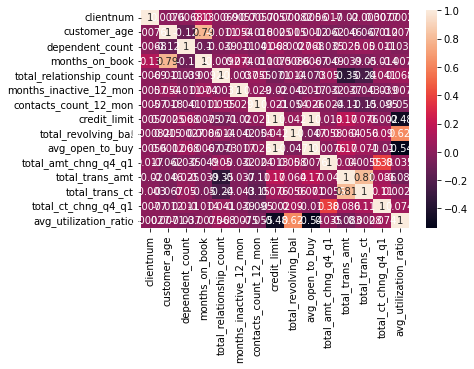

In [10]:
corr_mat = bank_df.corr()
sns.heatmap(corr_mat, annot = True);

Since there are so many predictors and likely high colinearity among variables, perhaps a tree-based model could be good for the dataset. Let's start preparing the data for modeling.

## Preparing for Modeling

First, we will split the data into `X` and `y`, holding our predictor and target variables respectively.

In [11]:
X = bank_df.drop(columns=["attrition_flag", "clientnum"])
y = bank_df.attrition_flag.to_numpy()

Next, we will encode the categorical variables by creating dummy variables for modeling in `X`, and encode `y` as a boolean with `0` if the customer is an **Existing Customer** or a `1` if they are an `Attrited Customer`.

In [12]:
X = pd.get_dummies(X)
y = [0 if row == "Existing Customer" else 1 for row in y]

Finally, we split our data into training, testing, and validation sets to compare how our model(s) perform.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=713
)

# Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=515
)

## Modeling 

We will try a few different tree-based models to see if we can predict customer attrition. Since this is a binary classification problem, we will measure success in terms of **precisio** or true positives. We will also look at **recall** and **AUC** scores.

#### Decision Tree Classifier

We will use a simple decision tree classifier first and see how our model performs. 

In [14]:
# Decision tree classifier. 
tree_clsfr = tree.DecisionTreeClassifier(criterion="gini", random_state=76)
tree_clsfr.fit(X_train, y_train)

DecisionTreeClassifier(random_state=76)

Now that the first model has been trained, let's define a function to return metrics for us.

In [15]:
def getPredsAndScores(model, X_train, X_val, y_train, y_val):
    preds = model.predict(X_train) # prediction using training data
    
    precision = metrics.precision_score(y_train, preds) # metrics 
    recall = metrics.recall_score(y_train, preds)
    auc_score = metrics.roc_auc_score(y_train, preds)

    tree_cv_score = cross_val_score(
        model, X_train, y_train, scoring="precision", cv=10
        ) # Cross validation score
    
    # print out results
    print(
        f"\nAverage CV Precision Score for model: {tree_cv_score.mean():.2%} \n"
        ) 

    print(f"Precision Score: {precision:.2%}")
    print(f"Recall Score: {recall:.2%}")
    print(f"AUC Score: {auc_score:.2%} \n")

    val_preds = model.predict(X_val) # prediction using val data

    val_precision = metrics.precision_score(y_val, val_preds) # val metrics
    val_recall = metrics.recall_score(y_val, val_preds)
    val_auc_score = metrics.roc_auc_score(y_val, val_preds)

    # print val data metrics 
    print(f"Validation Precision Score: {val_precision:.2%}")
    print(f"Validation Recall Score: {val_recall:.2%}")
    print(f"Validation AUC Score: {val_auc_score:.2%}")

We will be able to reuse this function as we try different models. Let's look at the scores and cross validation values from the first Decision Tree Classifier.

In [16]:
getPredsAndScores(tree_clsfr, X_train, X_val, y_train, y_val)


Average CV Precision Score for model: 79.64% 

Precision Score: 100.00%
Recall Score: 100.00%
AUC Score: 100.00% 

Validation Precision Score: 77.05%
Validation Recall Score: 80.20%
Validation AUC Score: 87.92%


Interesting results! Our training scores for precision, recall, and AUC were all 100%, while the validation scores were lower. This is a clear sign that our model is overfitting. Perhaps we can tweak the model to have a shallower depth to prevent overfitting.

#### Decision Tree With Lower Depth

We will define a Decision Tree Classifier model with a smaller depth.

In [17]:
# Above shows evidence of overfitting.
tree_clsfr_depth = tree.DecisionTreeClassifier(
    criterion="gini", max_depth=5 ,random_state=77
    )
tree_clsfr_depth.fit(X_train, y_train) 

DecisionTreeClassifier(max_depth=5, random_state=77)

In [18]:
getPredsAndScores(tree_clsfr_depth, X_train, X_val, y_train, y_val)


Average CV Precision Score for model: 76.35% 

Precision Score: 79.39%
Recall Score: 84.75%
AUC Score: 90.26% 

Validation Precision Score: 73.94%
Validation Recall Score: 83.28%
Validation AUC Score: 88.96%


Looks better! The model appears to not be overfitting as much as before. Our precision score lands at around 74%. We could see how it performs on the test data as well. Let's define a new function to handle the scores for the test data that will have no validation values.

In [19]:
def getTestScores(model, X_test=X_test, y_test=y_test):
    test_preds = model.predict(X_test)

    test_cv_score = cross_val_score(model, X_test, y_test, scoring="precision", cv=10)
    print(f"Average CV Precision Score: {test_cv_score.mean():.2%} \n")

    test_precision = metrics.precision_score(y_test, test_preds)
    test_recall = metrics.recall_score(y_test, test_preds)
    test_auc_score = metrics.roc_auc_score(y_test, test_preds)

    print(f"Precision Score: {test_precision:.2%}")
    print(f"Recall Score: {test_recall:.2%}")
    print(f"AUC Score: {test_auc_score:.2%}")

Great! Now let's use the function to see how the `tree_clsfr_depth` model performs on the test data.

In [20]:
# now on the test data
getTestScores(tree_clsfr_depth)

Average CV Precision Score: 74.64% 

Precision Score: 76.79%
Recall Score: 82.69%
AUC Score: 88.89%


Not bad! We got a true positive success rate of over 3/4s! 

Perhaps a model with multiple trees can work better.

#### Random Forest Model

We define a new Random Forest Classifier and fit it to the training data below.

In [21]:
# Try new random forest model 
rfc = RandomForestClassifier(n_estimators=3, random_state=10) 
# 3 appears to be a good number of estimators after a few tries. 
rfc.fit(X_train, y_train)

getPredsAndScores(rfc, X_train, X_val, y_train, y_val)


Average CV Precision Score for model: 81.39% 

Precision Score: 97.26%
Recall Score: 92.92%
AUC Score: 96.21% 

Validation Precision Score: 80.46%
Validation Recall Score: 71.67%
Validation AUC Score: 84.25%


In [22]:
getTestScores(rfc)

Average CV Precision Score: 79.22% 

Precision Score: 82.85%
Recall Score: 68.51%
AUC Score: 82.86%


We see a modest increase in precision using Random Forest. Let's see if a Gradient Boosted Classifier get's us a better result.

#### Gradient Boosted Classifier

Let's see if we can improve our score using this ensemble method to classify the individuals. 

In [23]:
gbc = GradientBoostingClassifier(random_state=10)
gbc.fit(X_train, y_train)

getPredsAndScores(gbc, X_train, X_val, y_train, y_val)


Average CV Precision Score for model: 92.96% 

Precision Score: 95.98%
Recall Score: 88.45%
AUC Score: 93.87% 

Validation Precision Score: 90.94%
Validation Recall Score: 85.67%
Validation AUC Score: 92.05%


The best score yet! Our model does not appear to be overfitting to the training data and the precision score is about 90%! Let's see the model in action on the testing data.

In [24]:
getTestScores(gbc)

Average CV Precision Score: 92.68% 

Precision Score: 92.41%
Recall Score: 87.74%
AUC Score: 93.16%


The model performed strongly on the test data showing a 92% true positive rate. 

## Summary 

Since the false negatives in this particular case (someone being labeled as attrition when they are not) is not a big concern, these tree-based models have shown that a high precision score is possible. We looked at Decision Tree Classifiers, a Random Forest model, and a Gradient Boosted Classifier model, and the Gradient Boosted Classifier performed the best. The model scored a precision of about 92% on the testing dataset.